In [1]:
import os
import json
import pickle
import sys
sys.path.insert(0, '../')
from src.DataSaver import DataSaver
from src.DynamicSystemAnalyzer import *
from src.PerformanceAnalyzer import *
from src.RNN_numpy import RNN_numpy
from src.utils import get_project_root, numpify, orthonormalize
from src.Trainer import Trainer
from src.RNN_torch import RNN_torch
from src.Task import *
from matplotlib import pyplot as plt
import torch
import time
from sklearn.decomposition import PCA
# from src.datajoint_config import *

In [2]:
disp = True
activation = "relu"
taskname = "CDDM"
config_dict = json.load(open(os.path.join(get_project_root(), "data", "configs", 'train_config_CDDM_relu;N=50;lmbdr=0.5;lmbdo=0.3.json'), mode="r"))

In [3]:
# defining RNN:
N = config_dict["N"]
activation_name = config_dict["activation"]
if activation_name == 'relu':
    activation = lambda x: torch.maximum(x, torch.tensor(0))
elif activation_name == 'tanh':
    activation = torch.tanh
elif activation_name == 'sigmoid':
    activation = lambda x: 1/(1 + torch.exp(-x))
elif activation_name == 'softplus':
    activation = lambda x: torch.log(1 + torch.exp(5 * x))

dt = config_dict["dt"]
tau = config_dict["tau"]
constrained = config_dict["constrained"]
connectivity_density_rec = config_dict["connectivity_density_rec"]
spectral_rad = config_dict["sr"]
sigma_inp = config_dict["sigma_inp"]
sigma_rec = config_dict["sigma_rec"]
seed = config_dict["seed"]
rng = torch.Generator()
if not seed is None:
    rng.manual_seed(seed)
input_size = config_dict["num_inputs"]
output_size = config_dict["num_outputs"]

In [4]:
# Task:
n_steps = config_dict["n_steps"]
task_params = config_dict["task_params"]

In [5]:
# Trainer:
lambda_orth = config_dict["lambda_orth"]
lambda_r = config_dict["lambda_r"]
mask = np.array(config_dict["mask"])
max_iter = config_dict["max_iter"]
tol = config_dict["tol"]
lr = config_dict["lr"]
weight_decay = config_dict["weight_decay"]
same_batch = config_dict["same_batch"]

In [6]:
config_dict["constrained"] = False

In [7]:
# General:
timestr = time.strftime("%Y%m%d-%H%M%S")
# data_folder = os.path.join(config_dict["data_folder"], timestr)

In [8]:
# creating instances:
rnn_torch = RNN_torch(N=N, dt=dt, tau=tau, input_size=input_size, output_size=output_size,
                      activation=activation, constrained=constrained,
                      sigma_inp=sigma_inp, sigma_rec=sigma_rec,
                      connectivity_density_rec=connectivity_density_rec,
                      spectral_rad=spectral_rad,
                      random_generator=rng)
task = eval("Task" + taskname)(n_steps=n_steps, n_inputs=input_size, n_outputs=output_size, task_params=task_params)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(rnn_torch.parameters(),
                             lr=lr,
                             weight_decay=weight_decay)
trainer = Trainer(RNN=rnn_torch, Task=task,
                  max_iter=max_iter, tol=tol,
                  optimizer=optimizer, criterion=criterion,
                  lambda_orth=lambda_orth, lambda_r=lambda_r)
datasaver = None

Using cpu for RNN!


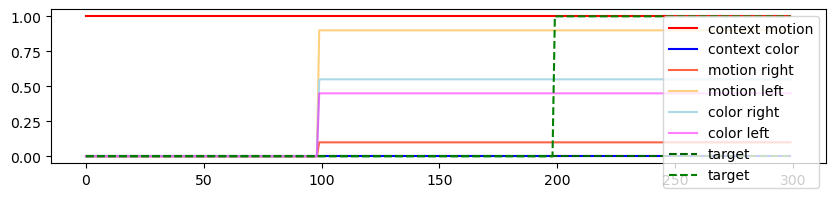

In [9]:
inputs, targets, conditions = task.get_batch()
ind = 11

fig = plt.figure(figsize = (10, 2))
plt.plot(inputs[0, :, ind], color = 'red', label = 'context motion')
plt.plot(inputs[1, :, ind], color = 'blue', label = 'context color')
plt.plot(inputs[2, :, ind], color = 'tomato', label = 'motion right')
plt.plot(inputs[3, :, ind], color = 'orange', alpha = 0.5, label = 'motion left')
plt.plot(inputs[4, :, ind], color = 'lightblue', label = 'color right')
plt.plot(inputs[5, :, ind], color = 'magenta', alpha = 0.5, label = 'color left')
plt.plot(targets[0, :, ind], color = 'darkgreen', linestyle = '--', label = 'target')
plt.plot(targets[1, :, ind], color = 'green', linestyle = '--', label = 'target')
plt.legend()
plt.show()

In [10]:
rnn_trained, train_losses, val_losses, net_params = trainer.run_training(train_mask=mask, same_batch=same_batch)

iteration 0, train loss: 1.918286
iteration 1, train loss: 1.78249
iteration 2, train loss: 1.787955
iteration 3, train loss: 1.791847
iteration 4, train loss: 1.791982
iteration 5, train loss: 1.787862
iteration 6, train loss: 1.781138
iteration 7, train loss: 1.771542


KeyboardInterrupt: 

In [ ]:
fig_trainloss = plt.figure(figsize=(10, 3))
plt.plot(train_losses, color='r', label='train loss (log scale)')
plt.plot(val_losses, color='b', label='valid loss (log scale)')
plt.yscale("log")
plt.grid(True)
plt.xlabel("# epoch", fontsize=16)
plt.ylabel("Loss", fontsize=16)
plt.legend(fontsize=16)
if disp:
    plt.show()
if not (datasaver is None): datasaver.save_figure(fig_trainloss, "train&valid_loss")

In [305]:
# validate
RNN_valid = RNN_numpy(N=net_params["N"],
                      dt=net_params["dt"],
                      tau=net_params["tau"],
                      activation=numpify(activation),
                      W_inp=net_params["W_inp"],
                      W_rec=net_params["W_rec"],
                      W_out=net_params["W_out"],
                      bias_rec=net_params["bias_rec"],
                      y_init=net_params["y_init"])

In [306]:
analyzer = PerformanceAnalyzerCDDM(RNN_valid)
score_function = lambda x, y: np.mean((x - y) ** 2)
input_batch_valid, target_batch_valid, conditions_valid = task.get_batch()
score = analyzer.get_validation_score(score_function, input_batch_valid, target_batch_valid,
                                      mask, sigma_rec=sigma_rec, sigma_inp=sigma_inp)

In [307]:
print(f"MSE validation: {np.round(score, 5)}")
if not (datasaver is None): datasaver.save_data(config_dict, "config.json")
if not (datasaver is None): datasaver.save_data(best_net_params, f"params_{taskname}_{np.round(score, 5)}.pkl")

MSE validation: 0.03354


Plotting random trials


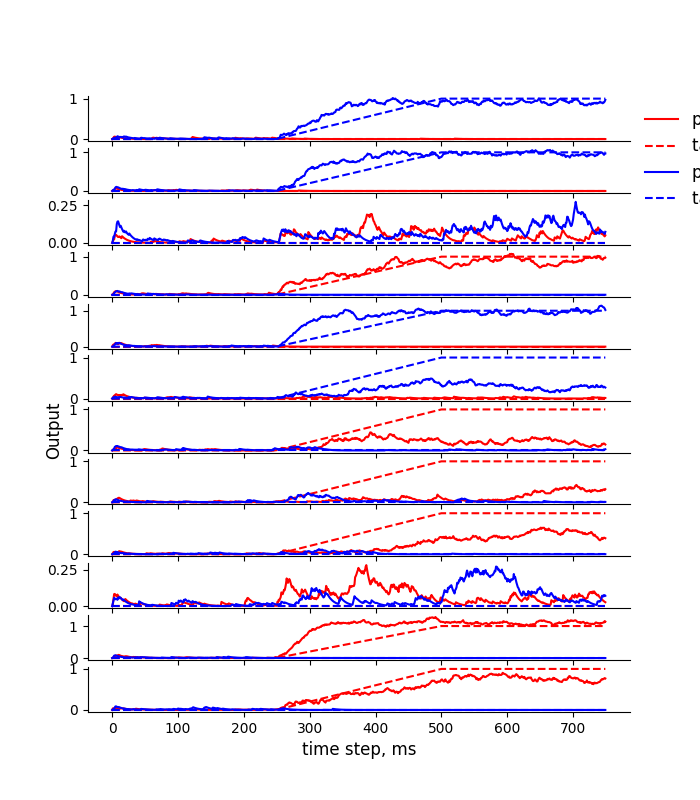

In [308]:
print(f"Plotting random trials")
inds = np.random.choice(np.arange(input_batch_valid.shape[-1]), 12)
inputs = input_batch_valid[..., inds]
targets = target_batch_valid[..., inds]

fig_trials = analyzer.plot_trials(inputs, targets, mask, sigma_rec=sigma_rec, sigma_inp=sigma_inp)
if disp:
    plt.show()
if not (datasaver is None): datasaver.save_figure(fig_trials, "random_trials")

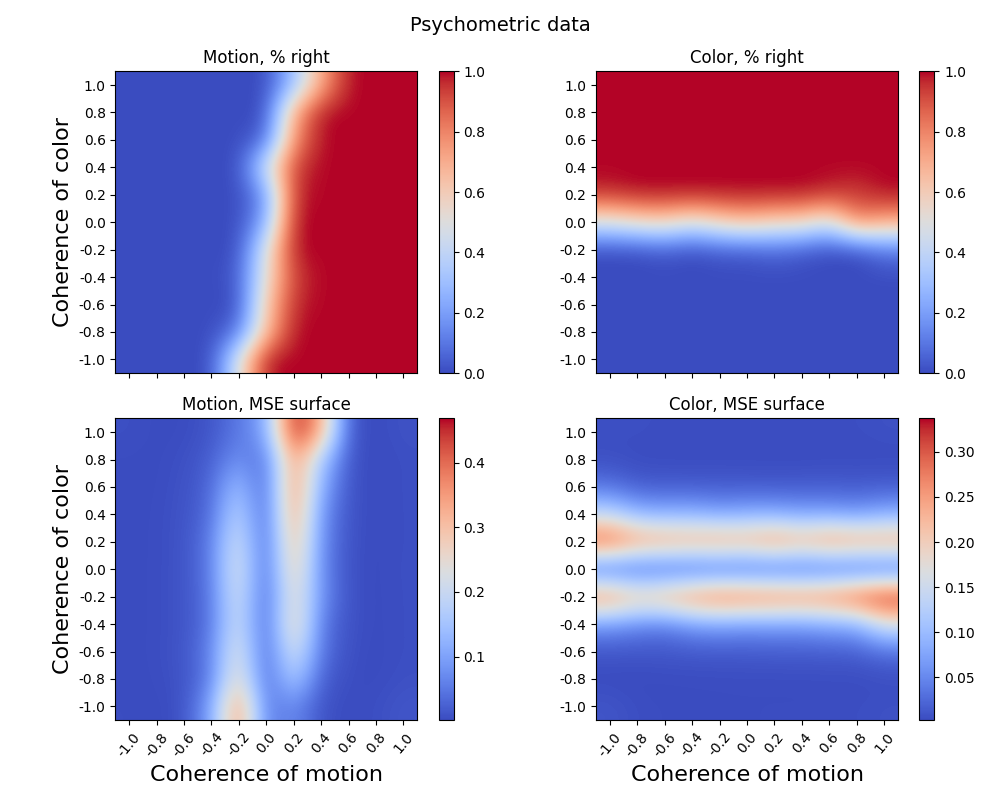

In [309]:
num_levels = len(config_dict["task_params"]["coherences"])
analyzer.calc_psychometric_data(task, mask, num_levels=num_levels, num_repeats=31, sigma_rec=0.03, sigma_inp=0.03)
fig_psycho = analyzer.plot_psychometric_data()
if disp:
    plt.show()
if not (datasaver is None): datasaver.save_figure(fig_psycho, "psychometric_data")

In [310]:
dsa = DynamicSystemAnalyzerCDDM(RNN_valid)
params = {"fun_tol" : 0.05,
          "diff_cutoff":1e-4,
          "sigma_init_guess":15,
          "patience":100,
          "stop_length":100,
          "mode":"approx"}
dsa.get_fixed_points(Input=np.array([1, 0, 0.5, 0.5, 0.5, 0.5]), **params)
dsa.get_fixed_points(Input=np.array([0, 1, 0.5, 0.5, 0.5, 0.5]), **params)
dsa.calc_LineAttractor_analytics()

Analyzing points on a line attractor in motion context...


  0%|          | 0/31 [00:00<?, ?it/s]

Analyzing points on a line attractor in color context...


  0%|          | 0/31 [00:00<?, ?it/s]

In [311]:
choice_axis = RNN_valid.W_out.flatten() if RNN_valid.W_out.shape[0] == 1 else (RNN_valid.W_out[0, :] - RNN_valid.W_out[1, :])
context_axis = RNN_valid.W_inp[:, 0] - RNN_valid.W_inp[:, 1]
sensory_axis = np.sum([RNN_valid.W_inp[:, i] for i in [2, 3, 4, 5]])

P_matrix = np.zeros((RNN_valid.N, 3))
P_matrix[:, 0] = choice_axis
P_matrix[:, 1] = context_axis
P_matrix[:, 2] = sensory_axis

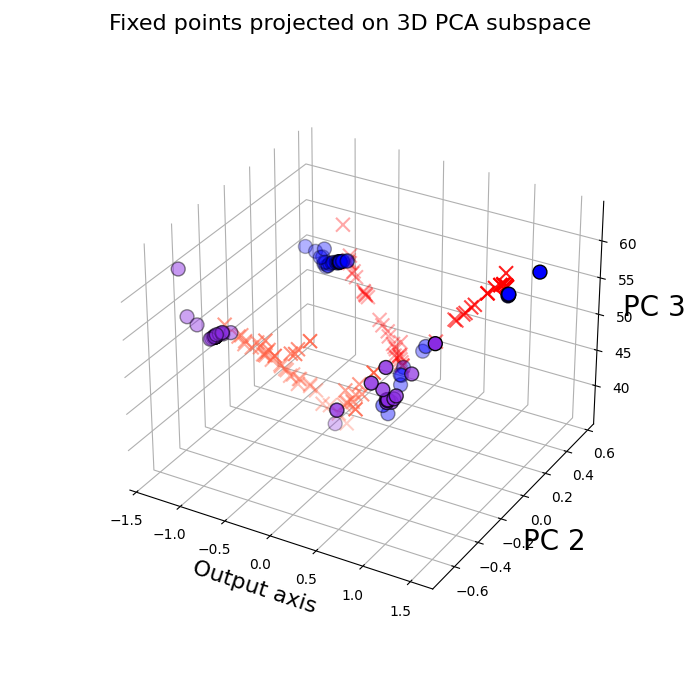

In [312]:
%matplotlib widget
fig_fp = dsa.plot_fixed_points(projection='3D', P=P_matrix)
plt.xlabel("Output axis", fontsize=16)
if disp:
    plt.show()

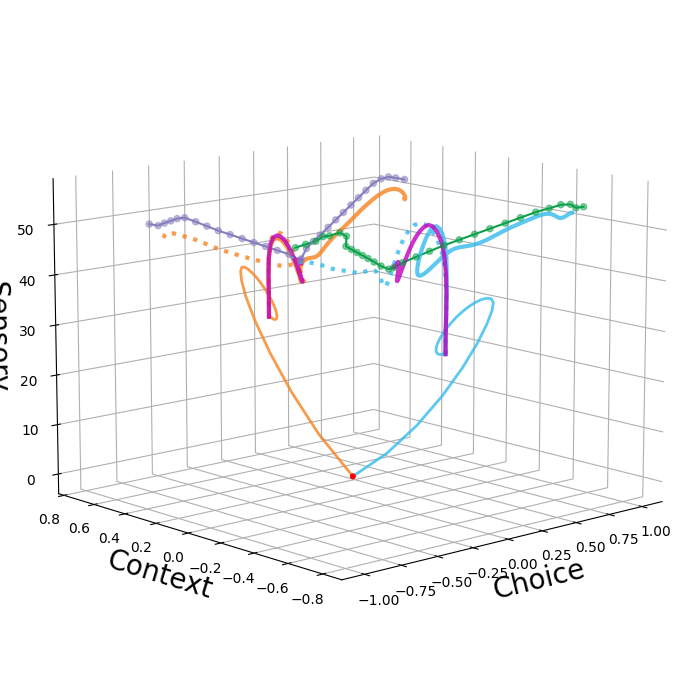

In [313]:
%matplotlib widget
fig_LA = dsa.plot_LineAttractor_3D()
if disp:
    plt.show()

# Saving the results into a database!

In [314]:
task_id = len(task_dj.fetch())
trainer_id = len(trainer_dj.fetch())
rnn_timestamp = time.strftime("%Y%m%d%H%M%S")

In [315]:
rnn_dj = RNNDJ()
task_dj = TaskDJ()
trainer_dj = TrainerDJ()
cddm_analysis_dj = CDDMRNNAnalysisDJ()

task_dj_dict = {"task_name": taskname + "_" + str(task_id),
                "n_steps": config_dict["n_steps"],
                "n_inputs": config_dict["num_inputs"],
                "n_outputs": config_dict["num_outputs"],
                "task_params": config_dict["task_params"],
                "mask": mask}
trainer_dj_dict = {"task_name": taskname + "_" + str(task_id),
                   "trainer_id": trainer_id,
                   "max_iter": config_dict["max_iter"],
                   "tol": config_dict["tol"],
                   "lr": config_dict["lr"],
                   "lambda_orth": config_dict["lambda_orth"],
                   "lambda_r": config_dict["lambda_r"],
                   "same_batch" : config_dict["same_batch"],
                   "shuffle" : False}
rnn_dj_dict = {"task_name": taskname + "_" + str(task_id),
               "rnn_timestamp" : rnn_timestamp,
               "trainer_id" : trainer_id,
               "n": config_dict["N"],
               "activation_name": config_dict["activation"],
               "constrained": config_dict["constrained"],
               "dt": config_dict["dt"],
               "tau": config_dict["tau"],
               "sr": config_dict["sr"],
               "connectivity_density_rec": config_dict["connectivity_density_rec"],
               "sigma_rec" : config_dict["sigma_rec"],
               "sigma_inp": config_dict["sigma_inp"],
               "w_inp" : net_params["W_inp"],
               "w_rec" : net_params["W_rec"],
               "w_out" : net_params["W_out"],
               "b_rec" : 0 if net_params["bias_rec"] is None else net_params["bias_rec"]}
cddm_analysis_dj_dict = {"task_name": taskname + "_" + str(task_id),
                         "rnn_timestamp" : rnn_timestamp,
                         "trainer_id": trainer_id,
                         "mse_score": score,
                         "psycho_data": deepcopy(analyzer.psychometric_data),
                         "fp_data": deepcopy(dsa.fp_data),
                         "la_data" : deepcopy(dsa.LA_data)}

In [316]:
task_dj.insert1(task_dj_dict, skip_duplicates=True)
trainer_dj.insert1(trainer_dj_dict, skip_duplicates=True)
rnn_dj.insert1(rnn_dj_dict, skip_duplicates=True)
cddm_analysis_dj.insert1(cddm_analysis_dj_dict, skip_duplicates=True)

In [317]:
trainer_dj

task_name,trainer_id,max_iter,tol,lr,lambda_orth,lambda_r,same_batch,shuffle
CDDM_0,0,400,1e-10,0.02,0.3,0.0,1,0
CDDM_1,0,600,1e-10,0.02,0.3,0.0,1,0
CDDM_1,1,600,1e-10,0.02,0.3,0.5,1,0
CDDM_2,3,600,1e-10,0.02,0.3,1.0,1,0
CDDM_3,4,600,1e-10,0.02,0.5,0.1,1,0
CDDM_4,5,600,1e-10,0.02,0.8,0.1,1,0
CDDM_5,6,600,1e-10,0.02,0.8,0.3,1,0
CDDM_6,7,600,1e-10,0.02,0.3,0.3,1,0
CDDM_7,8,600,1e-10,0.02,0.3,0.3,1,0
CDDM_8,9,600,1e-10,0.02,0.3,0.3,1,0


In [318]:
cddm_analysis_dj

task_name,trainer_id,rnn_timestamp unique model id,mse_score,fp_data,psycho_data,la_data
CDDM_0,0,20230125121936,0.0149129,=BLOB=,=BLOB=,=BLOB=
CDDM_0,0,20230125123953,0.0160775,=BLOB=,=BLOB=,=BLOB=
CDDM_1,0,20230125133836,0.0100973,=BLOB=,=BLOB=,=BLOB=
CDDM_1,0,20230125144552,0.0223644,=BLOB=,=BLOB=,=BLOB=
CDDM_1,1,20230125220230,0.0321081,=BLOB=,=BLOB=,=BLOB=
CDDM_1,1,20230125232004,0.0429012,=BLOB=,=BLOB=,=BLOB=
CDDM_2,3,20230126001153,0.0356656,=BLOB=,=BLOB=,=BLOB=
CDDM_3,4,20230126062746,0.0212487,=BLOB=,=BLOB=,=BLOB=
CDDM_4,5,20230126081013,0.0180888,=BLOB=,=BLOB=,=BLOB=
CDDM_5,6,20230126110601,0.0243252,=BLOB=,=BLOB=,=BLOB=


In [319]:
task_dj

task_name,n_steps,n_inputs,n_outputs,task_params,mask
CDDM_0,300,6,2,=BLOB=,=BLOB=
CDDM_1,450,6,2,=BLOB=,=BLOB=
CDDM_2,450,6,2,=BLOB=,=BLOB=
CDDM_3,450,6,2,=BLOB=,=BLOB=
CDDM_4,450,6,2,=BLOB=,=BLOB=
CDDM_5,450,6,2,=BLOB=,=BLOB=
CDDM_6,450,6,2,=BLOB=,=BLOB=
CDDM_7,450,6,2,=BLOB=,=BLOB=
CDDM_8,750,6,2,=BLOB=,=BLOB=
CDDM_9,750,6,2,=BLOB=,=BLOB=
